In [1]:
# import all the typical toolboxes...
from scipy.optimize import fsolve
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
from numpy import*
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cantera as ct

# Simple equilibrium example:

Determine the equilbrium concentrations for the following reaction at 1800K and 1 atm.

$$ \frac{1}{2} N_2 + \frac{1}{2}O_2 \leftrightarrow NO$$

Note that for this reaction, we'll need to look up the $K_{p,NO}$ from our JANAF Tables -- for this you can use the table in the Notes folder on Teams or you can refer to the JANAF database kept up by NIST, here: https://janaf.nist.gov/

In [2]:
# Set up the knowns
n_o2i = 0.21
n_n2i = 0.79
lnkp_no = -4.517 #note here we're using the value from the NIST site, which is slighty different from the handout

# Define our equations to solve
def eqn(vars):
    n2, o2, no = vars
    eq1 = 2*n_o2i - (2*o2 + no)
    eq2 = 2*n_n2i - (2*n2 + no)
    eq3 = exp(lnkp_no) - (no / (n2**0.5 * o2**0.5))
    return [eq1, eq2, eq3]

# Now call the fsolve function to solve our system of equatins
n2, o2, no = fsolve(eqn, (1, 1, 1,))

# Calculating mole fractions
ntot = n2 + o2 + no #total moles
x_n2 = n2/ntot
x_o2 = o2/ntot
ppmv_no = no/ntot * 1e6

print("x_N2 = %1.4f" % x_n2)
print("x_O2 = %1.4f" % x_o2)
print("ppmv_NO = %1.f ppmv" % ppmv_no)

x_N2 = 0.7878
x_O2 = 0.2078
ppmv_NO = 4419 ppmv


### Checking answers with Cantera:

Now let's check our answers with cantera:

In [3]:
# Cantera is already imported, so we just need to create a gas object
gas1 = ct.Solution('gri30.yaml')
#if we wanted to use a different mechanism
# gas1 = ct.Solution('burkeh2o2.yaml')

# Let's set what our gas is made of
gas1.X = {'N2':0.79, 'O2':0.21}

# Now set the temperature and pressure...
gas1.TP = 1800, 101325

# Finally, calculate the equilbrium gas concentrations based on the temp and pressure. Play around with different
# temps and pressures and see how it changes the concentrations below.
gas1.equilibrate('TP')
print('Let\'s look at the equilibrium gas properties:')
gas1() #show the gas properties

print('%=============== Now, picking out the main ones...')
# We can list specific elements
mf_n2 = gas1['N2'].X
print("The mole fraction of N2 is %1.4f " % mf_n2)

mf_o2 = gas1['O2'].X
print("The mole fraction of O2 is %1.4f " % mf_o2)

ppm_no = gas1['NO'].X * 1e6
print("The ppmv of NO is %1.0f ppmv " % ppm_no)

# check out here for list of gas properties: 
# https://cantera.org/documentation/docs-2.4/sphinx/html/cython/thermo.html

Let's look at the equilibrium gas properties:

  gri30:

       temperature   1800 K
          pressure   1.0132e+05 Pa
           density   0.19532 kg/m^3
  mean mol. weight   28.85 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        1.7309e+06        4.9937e+07  J
   internal energy        1.2122e+06        3.4971e+07  J
           entropy            8881.2        2.5622e+05  J/K
    Gibbs function       -1.4255e+07       -4.1126e+08  J
 heat capacity c_p            1246.4             35960  J/K
 heat capacity c_v            958.24             27645  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                 O        3.0749e-05        5.5448e-05           -14.983
                O2           0.23056           0.20788           -29.966
                 N        

# Equilibrium example with a hydrocarbon:

Now let's try one with more possibilities

$$ CH_4 + 2O_2 \rightarrow Products\left(CO_2, H_2O, CO, OH, O_2, H_2\right) $$

Let's assume this system reaches equilibrium at 2000K and 1 atm.

Note though, that since we have more produts than in the last example, we'll need some more $K_p$ values. Here, we'll need them for $OH$, $H_2O$, and $CO_2$.

In [4]:
# Set up the knowns
n_ch4 = 1
n_o2 = 2
# For these Kp's we're using the values from the handout
lnkp_oh = -0.4499
lnkp_h2o = 8.1521
lnkp_co2 = 6.6301

T = 2000 #K
P = 1 #atm

# Define our equations to solve
def eqn(vars):
    co2, h2o, co, oh, o2, h2, nt  = vars
    eq1 = n_ch4 - (co2 + co) #carbon balance
    eq2 = 2*n_o2 - (2*co2 + h2o + oh + 2*o2 + co) #oxygen balance
    eq3 = 4*n_ch4 - (2*h2o + oh + 2*h2) #hydrogen balance
    eq4 = exp(lnkp_oh)  - (oh  / (o2**0.5 * h2**0.5))*1 #Kp_OH
    eq5 = exp(lnkp_h2o) - (h2o / (h2 * o2**0.5))*(1/nt)**(-.5) #Kp_H2O
    eq6 = exp(lnkp_co2) - (co2 / (co * o2**0.5))*(1/nt)**(-.5) #Kp_CO2
    eq7 = nt - (co2 + h2o + co + oh + o2 + h2) #total moles
    return [eq1, eq2, eq3, eq4, eq5, eq6, eq7]

# Now call the fsolve function to solve our system of equatins
# also note that you'll need a pretty good guess here...
co2, h2o, co, oh, o2, h2, nt = fsolve(eqn, (.3, .7, .001, .001, .001, .001, 1))

# Calculating mole fractions
x_co2 = co2/nt
x_h2o = h2o/nt
ppmv_oh = oh/nt * 1e6

print("x_CO2 = %1.4f" % x_co2)
print("x_H2O = %1.4f" % x_h2o)
print("ppmv_OH = %1.f ppmv" % ppmv_oh)

x_CO2 = 0.3249
x_H2O = 0.6591
ppmv_OH = 2238 ppmv


### Checking answers with Cantera:

Now let's check our answers with cantera:

In [5]:
# Now we'll create a gas object
gas2 = ct.Solution('gri30.yaml')

#Let's set what our gas is made of
gas2.X = {'CH4':1/3, 'O2':2/3} #remember these shoudl be in mole fractions

#Now set the temperature and pressure...
gas2.TP = 2000, 101325

#Finally, calculate the equilbrium gas concentrations based on the temp and pressure. Play around with different
# temps and pressures and see how it changes the concentrations below.
gas2.equilibrate('TP')
#gas1() #show the gas properties

print("%===============") #just a print command to separate the outputs
# We can list specific elements
mf_co2 = gas2['CO2'].X
print("The mole fraction of CO2 is %1.4f " % mf_co2)

mf_h2o = gas2['H2O'].X
print("The mole fraction of H2O is %1.4f " % mf_h2o)

ppm_oh = gas2['OH'].X * 1e6
print("The ppmv of OH is %1.0f ppmv " % ppm_oh)

%===============
The mole fraction of CO2 is 0.3250 
The mole fraction of H2O is 0.6592 
The ppmv of OH is 1981 ppmv 


## Same example but with importing our $K_p$ table:

Another way we can try the previous example is by importing the relevant JANAF tabels from a *.csv file usign a toolbox calld "pandas," which will make looking at, and utilizing tables much easier.

Doing things this way will allow us to create code that will be more flexible and enable us to solve for a wider range of temperatures.

In [6]:
# The easiest way to use this is to have the *.csv file in the folder our jupyter notebook is in:
data = pd.read_csv("lnkp_v_temp.csv")
data #show the data

,T(K),CO+1/2O eq CO2,1/2H2 eq H,H2+1/2O eq H2O,1/2N2 eq N,1/2O2+1/2N2 eq NO,O2+1/2N2 eq NO2,1/2O2 eq O,1/2H2+1/2O2 eq OH
0,200.00,159.6811,-125.0847,139.9748,-277.2662,-53.3900,-27.9571,-142.7264,-20.5011
1,298.15,103.7531,-82.0006,92.2077,-183.7606,-35.3306,-21.1037,-93.4813,-13.1346
2,400.00,74.6618,-59.5794,67.3216,-135.1804,-25.9536,-17.6196,-67.8546,-9.3031
3,600.00,46.2378,-37.6127,42.8974,-87.6896,-16.7997,-14.2742,-42.7592,-5.5674
4,800.00,32.0310,-26.5668,30.5926,-63.8855,-12.2212,-12.6124,-30.1586,-3.7106
5,1000.00,23.5225,-19.9031,23.1622,-49.5719,-9.4731,-11.6103,-22.5729,-2.6070
6,1200.00,17.8648,-15.4375,18.1826,-40.0116,-7.6402,-10.9354,-17.5017,-1.8784
7,1400.00,13.8360,-12.2327,14.6115,-33.1715,-6.3305,-10.4473,-13.8705,-1.3634
8,1600.00,10.8245,-9.8185,11.9246,-28.0337,-5.3480,-10.0761,-11.1413,-0.9802
9,1800.00,8.4906,-7.9333,9.8304,-24.0323,-4.5838,-9.7835,-9.0144,-0.6848


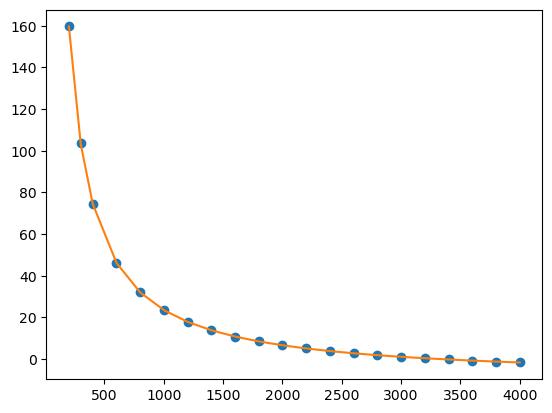

In [7]:
# Example of how we can use the data from our data table
TT = data['T(K)']
fkp_co2 = data['CO+1/2O eq CO2']

lnkp_co2 = interp1d(TT,fkp_co2) #setup a function that will interpolate within the bounds of our table above
# we can see how well the fxn interpolates
Tnew = arange(200,4000)
kpnew = lnkp_co2(Tnew)
plt.plot(TT,fkp_co2,'o', Tnew,kpnew,'-')
plt.show()

In [8]:
# Now let's setup some Kp fxns:
# import our required Kp eqns...
fkp_h2o = data['H2+1/2O eq H2O']
fkp_oh = data['1/2H2+1/2O2 eq OH']

lnkp_h2o = interp1d(TT,fkp_h2o)
lnkp_oh = interp1d(TT,fkp_oh)

In [9]:
# Finally, let's return to our CH4+O2 example above:
# Set up the knowns
n_ch4 = 1
n_o2 = 2

T = 2000 #K
P = 1 #atm

#check we're pulling the correct Kp's
print("lnkp_oh(T) %1.4f" % lnkp_oh(T))
print("lnkp_h2o(T) %1.4f" % lnkp_h2o(T))
print("lnkp_co2(T) %1.4f" % lnkp_co2(T))

# Define our equations to solve
def eqn(vars):
    co2, h2o, co, oh, o2, h2, nt  = vars
    eq1 = n_ch4 - (co2 + co) #carbon balance
    eq2 = 2*n_o2 - (2*co2 + h2o + oh + 2*o2 + co) #oxygen balance
    eq3 = 4*n_ch4 - (2*h2o + oh + 2*h2) #hydrogen balance
    eq4 = exp(lnkp_oh(T))  - (oh  / (o2**0.5 * h2**0.5))*1 #Kp_OH
    eq5 = exp(lnkp_h2o(T)) - (h2o / (h2 * o2**0.5))*(1/nt)**(-.5) #Kp_H2O
    eq6 = exp(lnkp_co2(T)) - (co2 / (co * o2**0.5))*(1/nt)**(-.5) #Kp_CO2
    eq7 = nt - (co2 + h2o + co + oh + o2 + h2) #total moles
    return [eq1, eq2, eq3, eq4, eq5, eq6, eq7]

# Now call the fsolve function to solve our system of equatins
# also note that you'll need a pretty good guess here...
co2, h2o, co, oh, o2, h2, nt = fsolve(eqn, (.3, .7, .001, .001, .001, .001, 1))

# Calculating mole fractions
x_co2 = co2/nt
x_h2o = h2o/nt
ppmv_oh = oh/nt * 1e6

print("x_CO2 = %1.4f" % x_co2)
print("x_H2O = %1.4f" % x_h2o)
print("ppmv_OH = %1.f ppmv" % ppmv_oh)

lnkp_oh(T) -0.4499
lnkp_h2o(T) 8.1521
lnkp_co2(T) 6.6301
x_CO2 = 0.3249
x_H2O = 0.6591
ppmv_OH = 2238 ppmv
